    tag     id   haplotype   fitness  fit_norm  local_peak  global_peak   N  K
0  nk-2  H0000  0000000000  0.491554  0.595437           0            0  10  2
1  nk-2  H0001  0000000001  0.640478  0.907836           0            0  10  2
2  nk-2  H0002  0000000010  0.381176  0.363894           0            0  10  2
3  nk-2  H0003  0000000011  0.519899  0.654897           0            0  10  2
4  nk-2  H0004  0000000100  0.454553  0.517819           0            0  10  2
0.0 1.0


<Figure size 640x480 with 0 Axes>

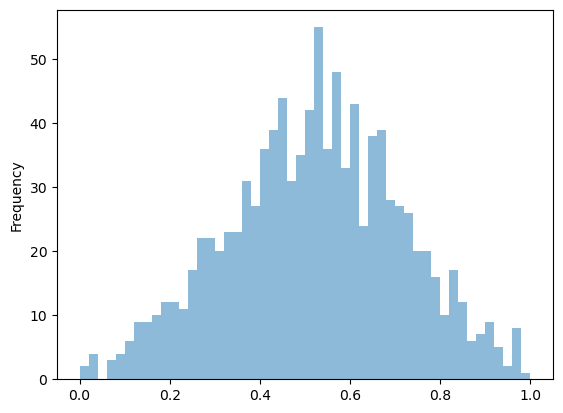

In [52]:
#construct 4-bit landscape
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# read input & collect all info into a dictionary
file = '../data/nk10/nk_2_landscape.tsv' # 10-bit landscape
df = pd.read_csv(file, delimiter="\t", dtype={'haplotype':str}) # hap column as strings (otherwise read as numbers)
print(df.head())
plt.figure()
#df['fit'].plot.hist(bins=10)
recs = df.to_dict("records")
dHap = {}
for rec in recs:
    dHap[rec['haplotype']] = {'id': rec['id'], 'fit': rec['fit_norm']}
#print(dHap)
plt.figure();
df['fit_norm'].plot.hist(alpha=0.5, bins =50);
#print(dHap)
print(min(df['fit_norm']), max(df['fit_norm'])) # unormalized

In [55]:
# build graph, add nodes & attach fitness as features
DG = nx.DiGraph() 
for hap in dHap: # hap as key
    DG.add_node(hap)
    for k in dHap[hap]: # k includes 'id' and 'fit'
        DG.nodes[hap][k] = dHap[hap][k]
    DG.nodes[hap]['alpha'] = dHap[hap]['fit'] # assign fitness as alpha (transparency)
#print(DG.nodes)


In [56]:
# now add edges & assign layers
# layout and draw Gallary:https://networkx.org/documentation/stable/auto_examples/index.html
def add_fit_edge(G, hap, seen, level):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        G.nodes[hap]['subset'] = level # networkx uses node feature 'subset' to store levels for multipartite layout
        nabes = [] # start a list of 1-hamming neighbors
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                if G.nodes[hap]['fit'] > G.nodes[mut]['fit']:
                    G.add_edge(mut, hap)
                else:
                    G.add_edge(hap, mut)
                nabes.append(mut)
        level += 1
        for x in nabes: # recurse on each child node
            if x not in seen: # skip if seen
                G.nodes[x]['subset'] = level
                add_fit_edge(G, x, seen, level)
seen_nodes = {}
add_fit_edge(DG, '0000000000', seen_nodes, 0) # start point
#print(DG.nodes())
#print(len(DG.edges()))

# node coloring by fitness 
#node_colors = range(10)
node_alphas = [ DG.nodes[x]['fit'] for x in DG.nodes]
#print(node_alphas)

peaks = [x[0] for x in DG.out_degree if x[1] == 0]
vals = [x[0] for x in DG.in_degree if x[1] == 0]
print(peaks)
print(vals)
print(len(peaks))
print(len(vals))

['0000111100', '0010010001', '0010110100', '0110110101', '1010011001', '1011011101', '1110111101']
['0001111111', '0100011111', '0101011011', '1001110111', '1100000110', '1101010011', '1101100110']
7
7


In [57]:
# Basin of attraction, according to Algorithm 1 by Verel et al
# greedy hill climbing from a random starting point
#######################
# The basin of attraction of a local optimum LOi ∈ S is the set bi = {s ∈ S | h(s)= LOi}. 
# h(s) is a solution of LOi, self inclusive
# The size of the basin of attraction of a local optimum i is the cardinality of bi, denoted #bi. 
# Notice that for non-neutral fitness landscapes, as are standard NK landscapes, 
# the basins of attraction as defined above, produce a partition of the configuration space S. 
# Therefore, S = ∪i∈S∗ bi and ∀i ∈ S ∀j = i, bi ∩ bj = ∅ (null, no intersections between basins).
############################################################

from numpy import random

def fit_diff(G, nd, suc):
    return G.nodes[suc]['fit'] - G.nodes[nd]['fit'] # must be positive

# recursive function
def greedy_climb(G, nd, pt):
    if nd in peaks: # a peak, no successors; but inclusive as a basin hap
        pt.append(nd)
        return
    best = sorted( [suc for suc in G.successors(nd)], key = lambda x: fit_diff(G, nd, x), reverse = True) # for each m -> n
    pt.append(best[0])
    greedy_climb(G, best[0], pt)

# Basin of attraction (should partition the haplotype space)
basins = {} # nuumber of paths to a peak (through greedy hill climbing)
for p in peaks: # initalize dict
    basins[p] = []

for nd_i in DG.nodes: # 1024 starting nodes
    #start = np.random.default_rng().choice(DG.nodes)
    path = []
    greedy_climb(DG, nd_i, path) # recursive until a peak
    peak = path[-1] # last item is the peak
    basins[peak].append(path)
    #print(path)

for p in basins:
    print(dHap[p]['id'], "\t", p, "\t", len(basins[p]), "\t", round(dHap[p]['fit'],6))


H0060 	 0000111100 	 93 	 0.764858
H0145 	 0010010001 	 169 	 0.969936
H0180 	 0010110100 	 52 	 0.830457
H0437 	 0110110101 	 95 	 0.96081
H0665 	 1010011001 	 120 	 0.978792
H0733 	 1011011101 	 270 	 1.0
H0957 	 1110111101 	 225 	 0.969666


In [58]:
# escape edge (more sparse than basin-transition edge)
# assymetric, to quote:
############################
# The escape edges are defined according to a distance function d (minimal number of moves between two solutions), 
# and a positive integer D>0.
# There exists an edge eij between LOi and LOj if it exists a solution s such that d(s, LOi) ≤ D and h(s)=LOj. 
# The weight wij of this edge is then: wij = #{s ∈ S | d(s, LOi) ≤ D and h(s)=LOj}, 
# which can be normalized by the number of solutions within reach with respect to such a distance:
# #{s ∈ S | d(s, LOi) ≤ D}.
# In English: if LOj can be reached after mutating LOi and running best improvement local descent from 
# the mutated solution
# Weighted by mutating LOi to reach other all LO 
############################################

from scipy.spatial.distance import hamming

D = 2 # mini distance between two solutions

# mutating i at a distance d<=D to reach j (for each solution of j): 
def distance_basin(basin, hap, d): # mutate hap to reach basin at a distance of d or fewer bits
    solutions = [x[0] for x in basin] # starting points in a basin
    dists = 0
    for i in solutions:
        d = hamming(list(i), list(hap)) * len(hap)
        if d <= D:
            dists += 1
    return(dists)

# mutation distance of i to reach all peaks, self inclusive
def distance_all(nodes, hap, d): # within the i, distance to j
    dists = 0
    for nd in nodes:
        basin = basins[nd]
        dists += distance_basin(basin, hap, d)
    return(dists)

escape = {}
for i in range(len(peaks)): # to each peak i
    hap_i = peaks[i]
    basin_i = basins[hap_i]
    total = distance_all(peaks, hap_i, D) # distances to peak i from all nodes
    for j in range(len(peaks)): # from aanother peak j
#        if i != j:
        hap_j = peaks[j]
        basin_j = basins[hap_j]
        dists = distance_basin(basin_j, hap_i, D) # distance of j basins to LOi 
        norm = dists/total
        if dists > 0:
            escape[ (hap_i, hap_j) ] = {'wt': norm, 'numb': dists, 'total': total}
    for e in escape:
        print(dHap[e[0]]['id'], "\t", e[0], "\t", dHap[e[1]]['id'], "\t", e[1],  "\t", round(escape[e]['wt'],4), "\t", escape[e]['numb'], "\t", escape[e]['total'])

H0060 	 0000111100 	 H0060 	 0000111100 	 0.6292 	 56 	 89
H0060 	 0000111100 	 H0145 	 0010010001 	 0.0674 	 6 	 89
H0060 	 0000111100 	 H0180 	 0010110100 	 0.1348 	 12 	 89
H0060 	 0000111100 	 H0437 	 0110110101 	 0.0562 	 5 	 89
H0060 	 0000111100 	 H0733 	 1011011101 	 0.0337 	 3 	 89
H0060 	 0000111100 	 H0957 	 1110111101 	 0.0787 	 7 	 89
H0060 	 0000111100 	 H0060 	 0000111100 	 0.6292 	 56 	 89
H0060 	 0000111100 	 H0145 	 0010010001 	 0.0674 	 6 	 89
H0060 	 0000111100 	 H0180 	 0010110100 	 0.1348 	 12 	 89
H0060 	 0000111100 	 H0437 	 0110110101 	 0.0562 	 5 	 89
H0060 	 0000111100 	 H0733 	 1011011101 	 0.0337 	 3 	 89
H0060 	 0000111100 	 H0957 	 1110111101 	 0.0787 	 7 	 89
H0145 	 0010010001 	 H0145 	 0010010001 	 0.5141 	 73 	 142
H0145 	 0010010001 	 H0180 	 0010110100 	 0.0211 	 3 	 142
H0145 	 0010010001 	 H0437 	 0110110101 	 0.0423 	 6 	 142
H0145 	 0010010001 	 H0665 	 1010011001 	 0.3169 	 45 	 142
H0145 	 0010010001 	 H0733 	 1011011101 	 0.1056 	 15 	 142
H0

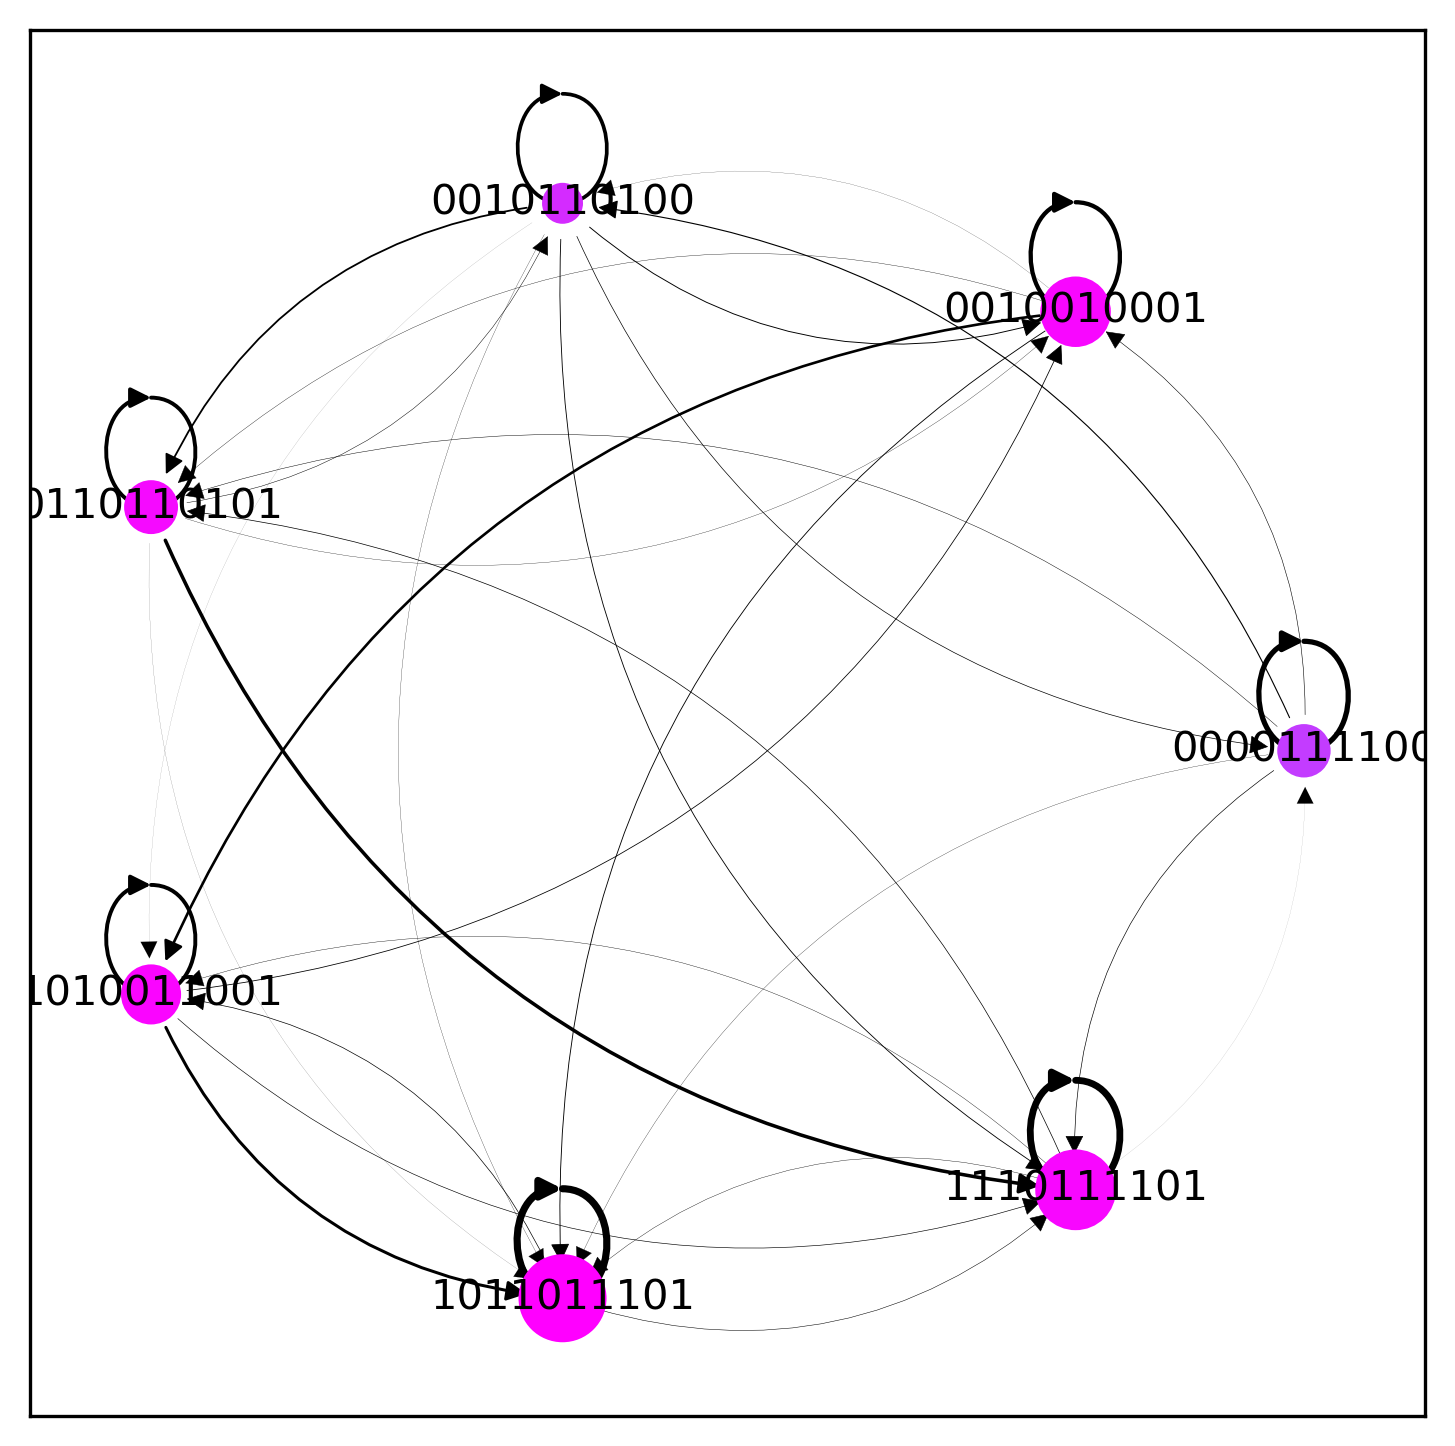

In [59]:
import matplotlib as mpl
import matplotlib.cm as cm

# plot LON
LON = nx.DiGraph()
for peak in peaks: # hap as key
    LON.add_node(peak)
    for k in dHap[peak]: # k includes 'id' and 'fit'
        LON.nodes[peak][k] = dHap[peak][k]
#print([dHap[n]['fit'] for n in LON.nodes])
        
for e in escape:
    LON.add_edge(e[0], e[1])
    LON.edges[e]['wt'] = escape[e]['wt']

# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
ndColors = [ mapper.to_rgba(LON.nodes[v]['fit']) for v in LON.nodes ] # colored by fitness
ndSizes = [ len(basins[p])*1.5 for p in LON.nodes ] # sized by basin size
egWidth = [ LON.edges[e]['wt']*2 for e in LON.edges ]  # edge width by weight

pos = nx.circular_layout(LON)
plt.figure(figsize = (6,6), dpi=300)
ec = nx.draw_networkx_edges(LON, pos, width=egWidth, connectionstyle="arc3,rad=0.3")
nc = nx.draw_networkx_nodes(LON, pos, 
                            node_color=ndColors, 
                            node_size=ndSizes, 
                            edgecolors=ndColors
                            )
nl = nx.draw_networkx_labels(LON, pos, font_size =10)
#plt.show()
#plt.savefig("lon-nk.png")


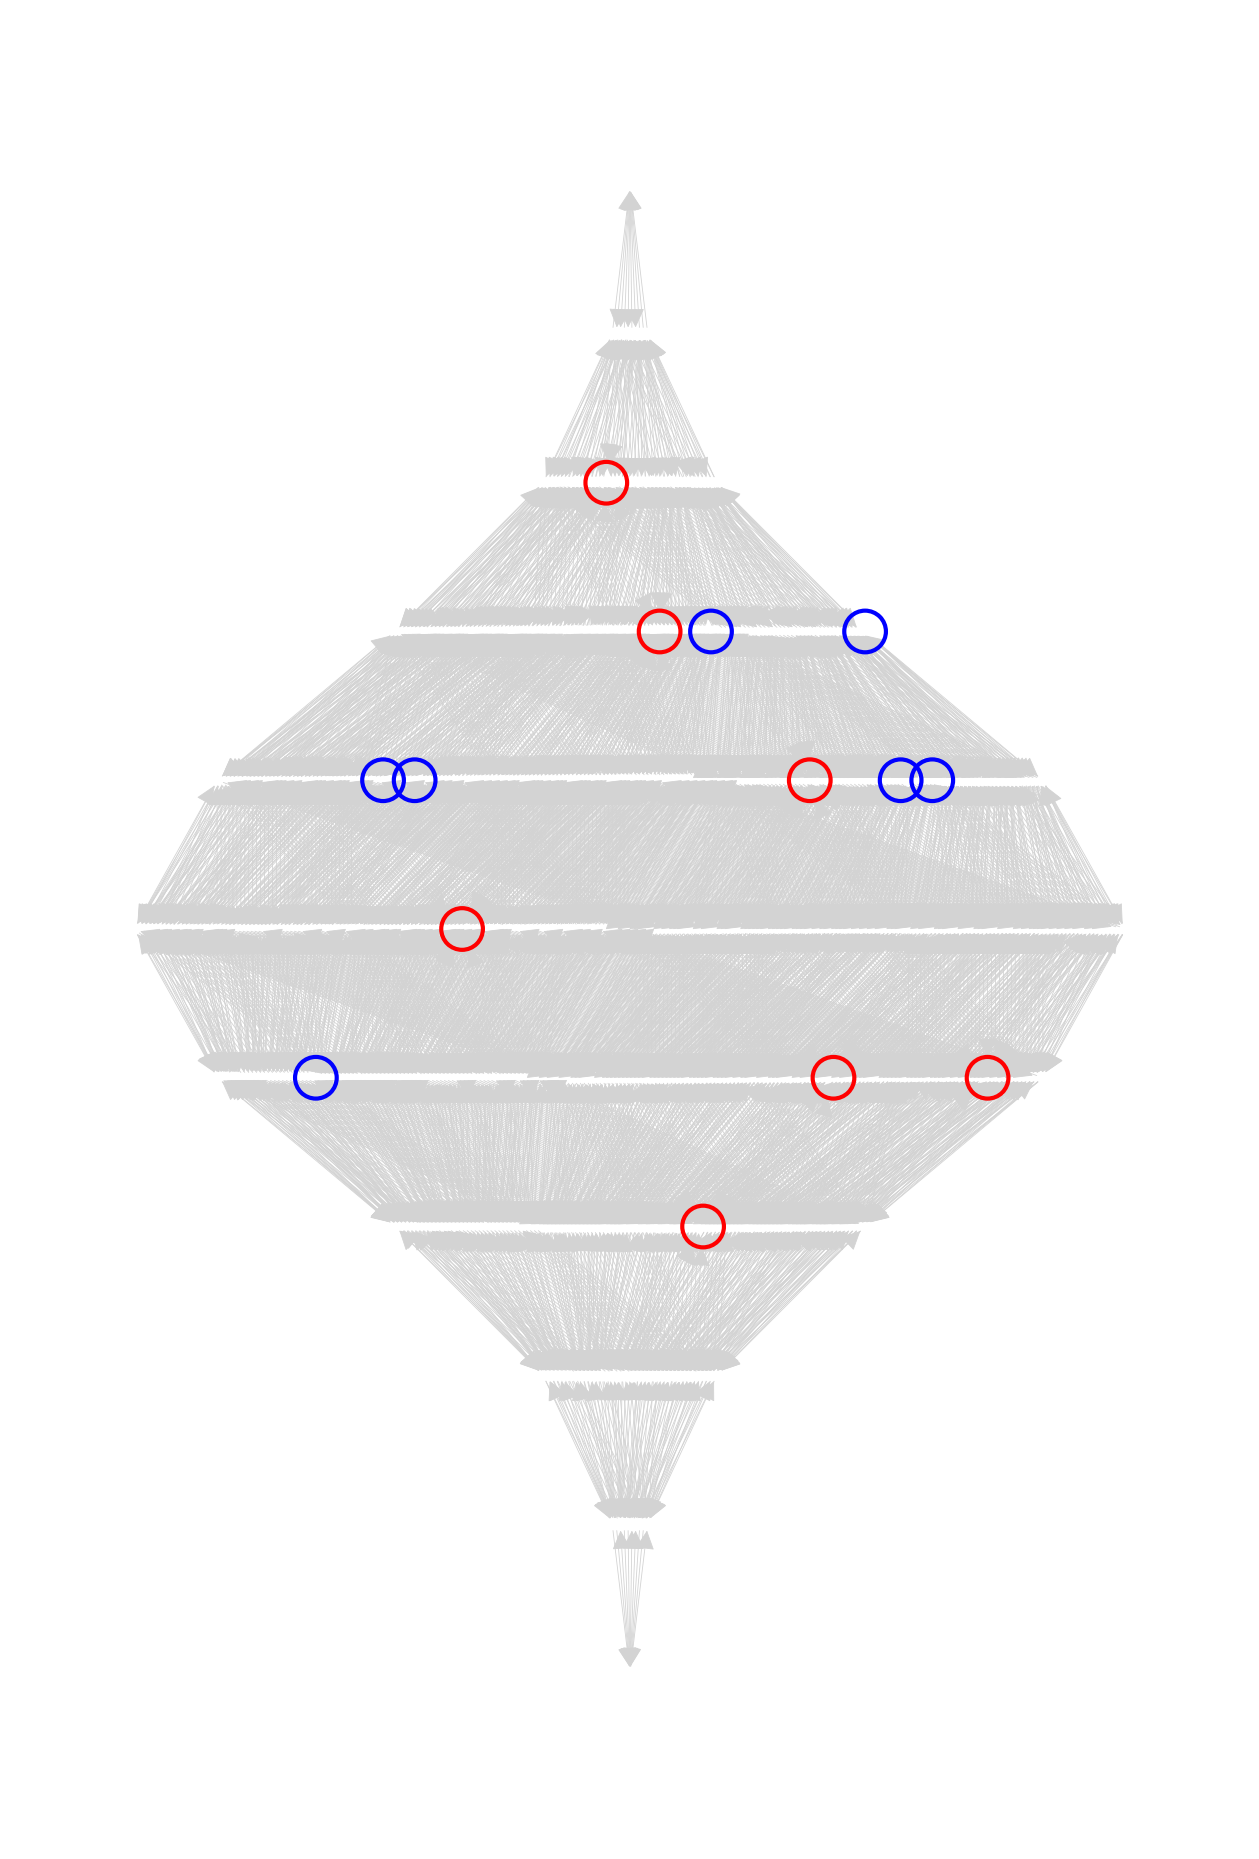

In [94]:
# multi-partite layout, subset by num of 0's
#ndColors = [  "orange" if x[1] == 0 else "white" for x in DG.out_degree() ]
ndColors = []
ndSizes = []
for x in DG.out_degree():
    if x[1] == 0:
        ndColors.append("red")
        ndSizes.append(100)
    elif x[1] == 10:
        ndColors.append("blue")
        ndSizes.append(100)
    else:
        ndColors.append("none")
        ndSizes.append(10)
    
#ndSizes = [  50 if x[1] == 0 else 10 for x in DG.out_degree() ]
pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (10,15), dpi=300)
plt.gcf().set_size_inches(4, 6)
nx.draw(DG, pos = pos,
        node_size = ndSizes,
        edge_color = "lightgray",
        edgecolors = ndColors,
        node_color = "none",
        width = 0.2
       )
#plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])

In [90]:
# degree analysis: fitness peak has only in_degrees and no out_degrees
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
#print(DG.in_degree()) # in-degree
#print(DG.out_degree()) # in-degree
in_deg = [x[1] for x in DG.in_degree()]
out_deg = [x[1] for x in DG.out_degree()]
haps = [x[0] for x in DG.in_degree()]
fits = [DG.nodes[x]['fit'] for x in DG.nodes]
ids = [DG.nodes[x]['id'] for x in DG.nodes]
#print(in_deg)
#print(out_deg)
#print(haps)
dfDeg = pd.DataFrame({'hap': haps, 'in_deg': in_deg, 'out_deg':out_deg, 'fit':fits, 'id': ids} )
#print(dfDeg.head())

###################
# plot subgraph with 3D 
peaks = dfDeg[dfDeg['out_deg'] == 0] # local and global peaks
vals = dfDeg[dfDeg['in_deg'] == 0] # fitness valleys
#dfDeg.plot.bar(x = 'hap', stacked = True)
#dfDeg.plot.bar(x = 'hap', subplots = True)

peakHap = peaks.sort_values(by = ['fit'])['hap'].tolist()[-1]
valHap = vals.sort_values(by = ['fit'])['hap'].tolist()[0]
peakG = nx.ego_graph(DG, peakHap, radius=1, center=True, undirected=True, distance=None)
valG = nx.ego_graph(DG, valHap, radius=1, center=True, undirected=True, distance=None)
#print(peakHap)
#print(peakG.nodes())

'''
# spring layout
pos = nx.spring_layout(peakG, dim=3, seed=779)
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(peakG)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in peakG.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("fitness")


#_format_axes(ax)
#fig.tight_layout()
#plt.show()
'''
print(peaks)
print(vals)
print(peakHap)
print(valHap)

1011011101
['1011011101', '1011011111', '1001011101', '1011011001', '1011011100', '1011001101', '1011111101', '1111011101', '0011011101', '1011010101', '1010011101']
            hap  in_deg  out_deg       fit     id
60   0000111100      10        0  0.764858  H0060
145  0010010001      10        0  0.969936  H0145
180  0010110100      10        0  0.830457  H0180
437  0110110101      10        0  0.960810  H0437
665  1010011001      10        0  0.978792  H0665
733  1011011101      10        0  1.000000  H0733
957  1110111101      10        0  0.969666  H0957
            hap  in_deg  out_deg       fit     id
127  0001111111       0       10  0.072493  H0127
287  0100011111       0       10  0.082999  H0287
347  0101011011       0       10  0.156229  H0347
631  1001110111       0       10  0.004633  H0631
774  1100000110       0       10  0.028274  H0774
851  1101010011       0       10  0.088369  H0851
870  1101100110       0       10  0.000000  H0870
1011011101
1101100110


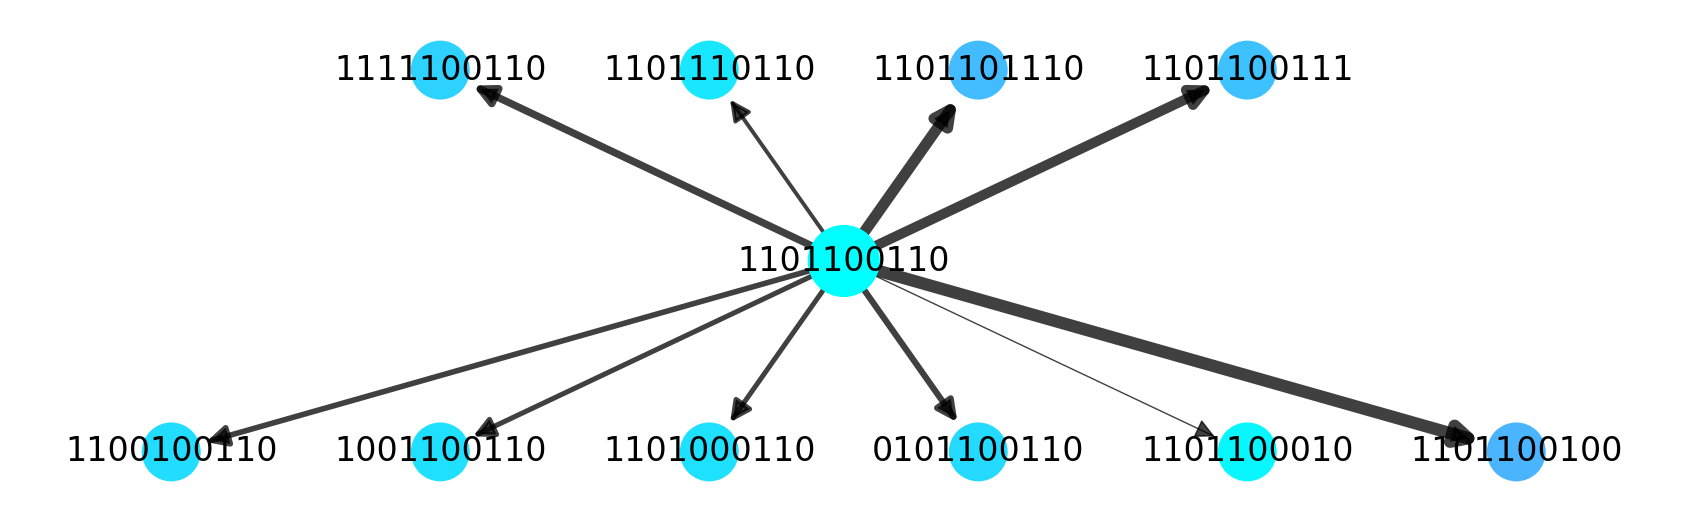

In [101]:
'''
# Test case: add edges recursively
# The total number of unique binary haps of length n is the sum of binomial coefficients
# which evaluates to 2^n (https://mathworld.wolfram.com/BinomialSums.html)
# The total number of 1-bit edges is: n2^2 - n*2^(n-1) = n* 2^(n-1)
def add_edge_test(G, hap, outList, k, seen):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        nabes = {'level':k, 'hap_list': []} # start a list
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                nabes['hap_list'].append(mut)
        outList.append(nabes) # append hap list to output list
        k += 1 # next level
        for x in nabes['hap_list']: # recurse on each child node
            if x not in seen: # skip if seen
                add_edge_test(G, x, outList, k, seen)

out = []
seen_nodes = {}
add_edge_test(DG, '00000', out, 1, seen_nodes) # start recursion at '0000'
levels = np.unique(np.array([x['level'] for x in out]))
for lev in levels:
    flat = []
    hap = [x['hap_list'] for x in out if x['level'] == lev]
    for h in hap:
        flat.append(h)
    print(lev, ":", np.unique(np.array(flat)))
#print(out)
#for x in out:
#    print(x)   
'''
valFits = [valG.nodes[x]['fit'] for x in valG.nodes]
# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
valNodeColors = [ mapper.to_rgba(v) for v in valFits  ]
#print(peakNodeColors)

# highlight center
valNodeSizes = [ 300 if x == valHap  else 200 for x in valG.nodes ]
valNodeEdges = [ "black" if x == peakHap  else "none" for x in valG.nodes ]
valEdgeWidth = [ abs(valG.nodes[x[0]]['fit']-valG.nodes[x[1]]['fit'])*10 for x in valG.edges()]

# plot nodes and edges seprately
pos = nx.multipartite_layout(valG, align = 'horizontal')
plt.figure(figsize = (6,3), dpi=300)
ec = nx.draw_networkx_edges(valG, pos, alpha=0.75, width=valEdgeWidth)
nc = nx.draw_networkx_nodes(valG, pos,  
                            node_color=valNodeColors, 
                            node_size=valNodeSizes, 
                            edgecolors=valNodeEdges
                            )
nl = nx.draw_networkx_labels(valG, pos, font_size = 8)
#pc = mpl.collections.PatchCollection(nc, cmap=cmap)
#ax = plt.gca()
#ax.set_axis_off()
#plt.colorbar(pc, label='Fitness')

#plt.figure(dpi=300)
plt.axis('off')
plt.gcf().set_size_inches(7, 2)
#plt.figure.set_size_inches(3, 3)
plt.savefig("valley.pdf")

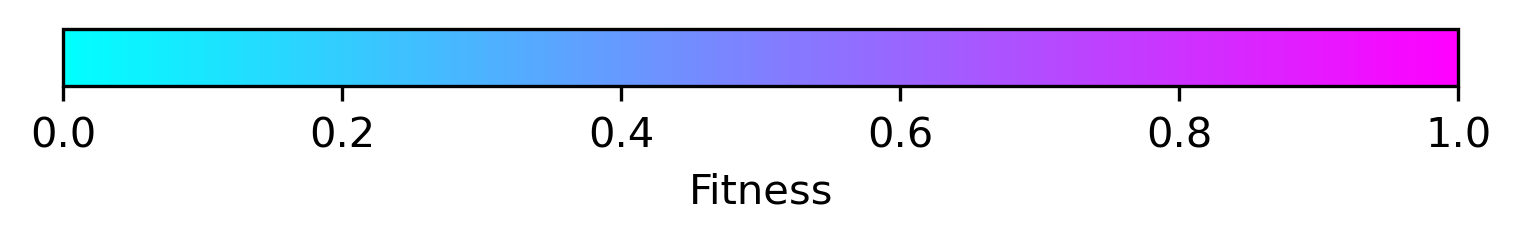

In [84]:
fig, ax = plt.subplots(figsize=(6, 0.5), dpi = 300)
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Fitness')
plt.savefig("colorbar.pdf")

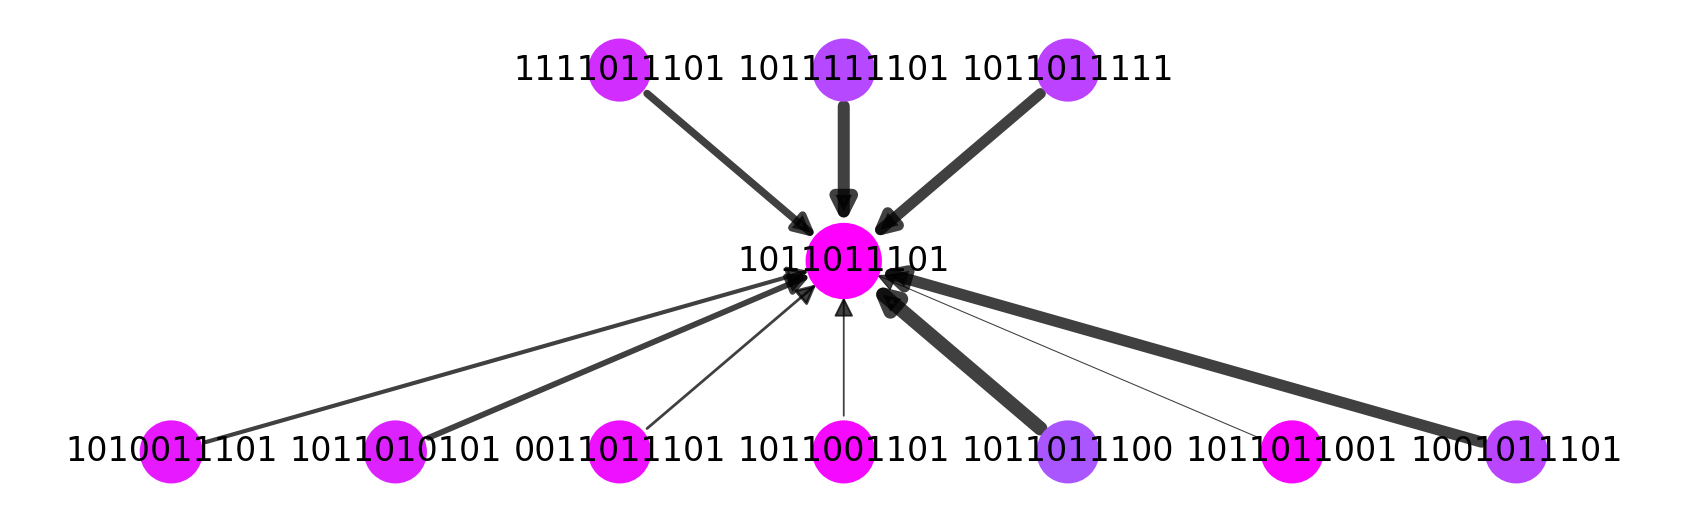

In [100]:
# Draw graph
#pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
#nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

#from itertools import count
#groups = set(nx.get_node_attributes(peakG,'fit').values())
#print(groups)
#mapping = dict(zip(sorted(groups),count()))
#print(mapping)
#nodes = peakG.nodes()
#colors = [mapping[peakG.nodes[n]['fit']] for n in nodes]

#M = peakG.number_of_nodes()
#node_alphas = [(5 + i) / (M + 4) for i in range(M)]
#node_colors = range(0, 1)
#node_alphas = set(nx.get_node_attributes(peakG,'fit').values())
#node_colors = range(nx.get_node_attributes(peakG,'fit').values())
#cmap = plt.cm.plasma
# drawing nodes and edges separately so we can capture collection for colobar
#pos = nx.spring_layout(g)
#plt.show()

# Draw ego as large and red
#import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

peakFits = [peakG.nodes[x]['fit'] for x in peakG.nodes]
#print(peakFits)
#fmin = min(peakFits)
#fmax = max(peakFits)
#print(fmin, fmax)

#fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
#fig = plt.subplots(1, figsize=(7, 3))
#for ax in axs.flat:
#    im = ax.pcolormesh(arr, **pc_kwargs)
#fig.colorbar(im, ax=axs, shrink=0.6)
#fig, ax = plt.subplots(figsize=(7, 1))
#fig.subplots_adjust(top=0.5)
#plt.colorbar(nc)

# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
peakNodeColors = [ mapper.to_rgba(v) for v in peakFits  ]
#peakLabels = peakG.nodes()
#print(peakNodeColors)

# highlight center
peakNodeSizes = [ 300 if x == peakHap  else 200 for x in peakG.nodes ]
peakNodeEdges = [ "black" if x == peakHap  else "none" for x in peakG.nodes ]
peakEdgeWidth = [ abs(peakG.nodes[x[0]]['fit']-peakG.nodes[x[1]]['fit'])*10 for x in peakG.edges()]

# plot nodes and edges seprately
pos = nx.multipartite_layout(peakG, align = 'horizontal')
#print(pos)
plt.figure(dpi=300)
ec = nx.draw_networkx_edges(peakG, pos, alpha=0.75, width=peakEdgeWidth)
nc = nx.draw_networkx_nodes(peakG, pos, 
                            node_color=peakNodeColors, 
                            node_size=peakNodeSizes, 
#                            edgecolors=peakNodeEdge
                            )
nl = nx.draw_networkx_labels(peakG, pos, font_size =8)
#pc = mpl.collections.PatchCollection(nc, cmap=cmap)
#ax = plt.gca()
#ax.set_axis_off()
#plt.colorbar(pc, label='Fitness')

plt.axis('off')
plt.gcf().set_size_inches(7, 2)
#plt.figure(figsize = (6,3), dpi=300)
plt.savefig("peak.pdf")
#plt.show()